In [147]:
import sys

import agama
import halo_analysis as halo
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import interp1d

In [150]:
sim = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"
fire_dir = sim_dir + sim + "/" + sim + "_res7100"

pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"

pub_data = sim_dir + "snapshot_times_public.txt"
pub_snaps = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
pub_snaps.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

In [29]:
def get_type_flag(gc, grp, gc_survive_lst):
    if gc in gc_survive_lst:
        if grp == 0:
            # formed in-situ and survived to z = 0
            type_flag = 0
        elif grp > 0:
            # formed ex-situ, accreted and survived to z = 0
            type_flag = 2

    elif grp < -2:
        # formed ex-situ and died before accretion
        type_flag = 4

    elif grp > 0:
        # formed ex-situ, accreted but died before z = 0
        type_flag = 3

    elif grp == 0:
        # formed in-situ, but died before z = 0
        type_flag = 1

    else:
        sys.exit("Some GC Missing Type Flag")

    return type_flag

In [41]:
proc_data["it000"]["snapshots"]["snap041"].keys()

<KeysViewHDF5 ['acc_snap', 'gc_id', 'group_id', 'mass', 'now_accreted', 'ptype', 'survived_accretion']>

In [ ]:
it = 0
pot_limit = 46

#############################################################################################
it_id = iteration_name(it)
src_data = proc_data[it_id]["source"]
ana_flag = np.array(src_data["analyse_flag"]) == 1

gc_survive_lst = [gc for gc in proc_data[it_id]["snapshots"]["snap600"]["gc_id"]]
gc_lst = np.array(src_data["gc_id"][ana_flag])
grp_lst = np.array(src_data["group_id"][ana_flag])

type_flag_lst = [get_type_flag(gc, grp, gc_survive_lst) for gc, grp in zip(gc_lst, grp_lst)]

t_form_lst = np.array(src_data["form_time"][ana_flag])

#############################################################################################

In [136]:
r_birth_lst = []

i = 1
i_max = len(t_form_lst)
for gc, t_form in zip(gc_lst, t_form_lst):
    print(i, "/", i_max)
    i += 1
    # t_form = t_form_lst[idx]

    pot_snap = pub_snaps[pub_snaps["index"] >= pot_limit].reset_index(drop=True)

    prop_idx = np.argmin(np.abs(t_form - pot_snap["time_Gyr"]))
    prop_pot = pot_snap["index"][prop_idx]

    snap_id = snapshot_name(prop_pot)

    snap_data = proc_data[it_id]["snapshots"][snap_id]

    mask = np.array(snap_data["gc_id"]) == gc

    x = np.array(snap_data["x"][mask])

    if len(x) == 0:
        continue

    x = x[0]
    y = np.array(snap_data["y"][mask])[0]
    z = np.array(snap_data["z"][mask])[0]

    vx = np.array(snap_data["vx"][mask])[0]
    vy = np.array(snap_data["vy"][mask])[0]
    vz = np.array(snap_data["vz"][mask])[0]

    init_cond = [x, y, z, vx, vy, vz]

    dt = t_form - pot_snap["time_Gyr"][prop_idx]

    potential_file = pot_dir + sim + "/snap_%d/combined_snap_%d.ini" % (prop_pot, prop_pot)
    pot_nbody = agama.Potential(potential_file)

    time, posvel = agama.orbit(potential=pot_nbody, ic=init_cond, time=dt, trajsize=1)
    pos = posvel[:3]
    r = np.linalg.norm(pos)

    r_birth_lst.append([gc, r])

1 / 12322
2 / 12322
3 / 12322
4 / 12322
5 / 12322
6 / 12322
7 / 12322
8 / 12322
9 / 12322
10 / 12322
11 / 12322
12 / 12322
13 / 12322
14 / 12322
15 / 12322
16 / 12322
17 / 12322
18 / 12322
19 / 12322
20 / 12322
21 / 12322
22 / 12322
23 / 12322
24 / 12322
25 / 12322
26 / 12322
27 / 12322
28 / 12322
29 / 12322
30 / 12322
31 / 12322
32 / 12322
33 / 12322
34 / 12322
35 / 12322
36 / 12322
37 / 12322
38 / 12322
39 / 12322
40 / 12322
41 / 12322
42 / 12322
43 / 12322
44 / 12322
45 / 12322
46 / 12322
47 / 12322
48 / 12322
49 / 12322
50 / 12322
51 / 12322
52 / 12322
53 / 12322
54 / 12322
55 / 12322
56 / 12322
57 / 12322
58 / 12322
59 / 12322
60 / 12322
61 / 12322
62 / 12322
63 / 12322
64 / 12322
65 / 12322
66 / 12322
67 / 12322
68 / 12322
69 / 12322
70 / 12322
71 / 12322
72 / 12322
73 / 12322
74 / 12322
75 / 12322
76 / 12322
77 / 12322
78 / 12322
79 / 12322
80 / 12322
81 / 12322
82 / 12322
83 / 12322
84 / 12322
85 / 12322
86 / 12322
87 / 12322
88 / 12322
89 / 12322
90 / 12322
91 / 12322
92 / 123

(array([ 703., 1162.,  563.,  773.,  438.,  186.,   27.,    4.,    0.,
           2.]),
 array([  0.        ,  43.17254333,  86.34508667, 129.51763   ,
        172.69017334, 215.86271667, 259.03526001, 302.20780334,
        345.38034668, 388.55289001, 431.72543335]),
 <BarContainer object of 10 artists>)

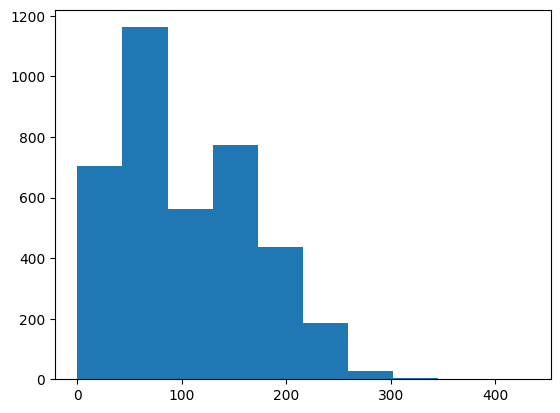

In [146]:
plt.hist(np.array(r_birth_lst)[:, 1])

In [151]:
halt = halo.io.IO.read_tree(
    simulation_directory=fire_dir,
    species="star",
    species_snapshot_indices=[600],
    assign_species_pointers=True,
)


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt


# in halo_analysis.halo_io.IO():
* read 17859038 halos from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5
  
* assigning ['star'] properties to halo merger trees

# in halo_analysis.halo_io.Particle():
* read 35838 halos, 55 have star particles, from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/halo/rockstar_dm/catalog_hdf5/star_600.hdf5

# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt

! cannot find star particle pointer file at snapshot 600 in /Users/z5114326/Documents/simulations/m12i/m12i_res7100/
  dark2.mass
  star.form.time.100
  star.form.time.50
  star.form.time.90
  star.form.time.95
  star.form.time.dif.68
  star.indices
  star.mass
  star.massfraction
  star.number
  star.position
  star.radius.50
  star.radius.9

In [152]:
for key in halt.keys():
    if "star" in key:
        print(key)

star.form.time.100
star.form.time.50
star.form.time.90
star.form.time.95
star.form.time.dif.68
star.indices
star.mass
star.massfraction
star.number
star.position
star.radius.50
star.radius.90
star.vel.std
star.vel.std.50
star.velocity


In [159]:
halt["star.mass"][0]

62915195000.0

In [174]:
proc_data["it000"]["snapshots"]["snap600"].keys()

<KeysViewHDF5 ['acc_snap', 'bound_flag', 'ecc', 'ek', 'ep_agama', 'ep_fire', 'et', 'et_norm', 'gc_id', 'group_id', 'jphi', 'jr', 'jz', 'lx', 'ly', 'lz', 'lz_norm', 'mass', 'now_accreted', 'phi_cyl', 'ptype', 'r', 'r_apo', 'r_cyl', 'r_per', 'survived_accretion', 'vphi_cyl', 'vr_cyl', 'vx', 'vy', 'vz', 'x', 'y', 'z']>

In [ ]:
x = proc_data["it000"]["snapshots"]["snap600"]["x"][()]
y = proc_data["it000"]["snapshots"]["snap600"]["x"][()]
z = proc_data["it000"]["snapshots"]["snap600"]["x"][()]

r_lst = [np.linalg.norm([xi, yi, zi]) for xi, yi, zi in zip(x, y, z)]
grp_lst = proc_data["it000"]["snapshots"]["snap600"]["group_id"][()]

log_mass_lst = proc_data["it000"]["snapshots"]["snap600"]["mass"][()]
mass_lst = 10**log_mass_lst

In [240]:
unique_values, counts = np.unique(grp_lst, return_counts=True)
grp_unq = [grp for grp, cnts in zip(unique_values, counts) if cnts > 10]

Text(0, 0.5, 'Count')

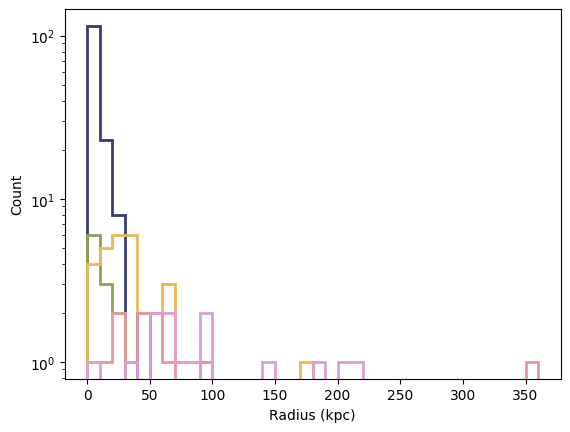

In [241]:
num_groups = len(grp_unq)
cmap = plt.get_cmap("tab20b")
colors = [cmap(i / (num_groups - 1) if num_groups > 1 else 0.5) for i in range(num_groups)]

# Create a dictionary mapping group_id to color
group_colors = {group_id: colors[i] for i, group_id in enumerate(grp_unq)}

bins = np.linspace(0, 360, 37)
for grp in grp_unq:
    grp_mask = grp_lst == grp
    r_hist = np.array(r_lst)[grp_mask]

    plt.hist(r_hist, bins=bins, color=group_colors[grp], histtype="step", lw=2)

plt.yscale("log")

plt.xlabel("Radius (kpc)")
plt.ylabel("Count")

Text(0, 0.5, 'Radius (kpc)')

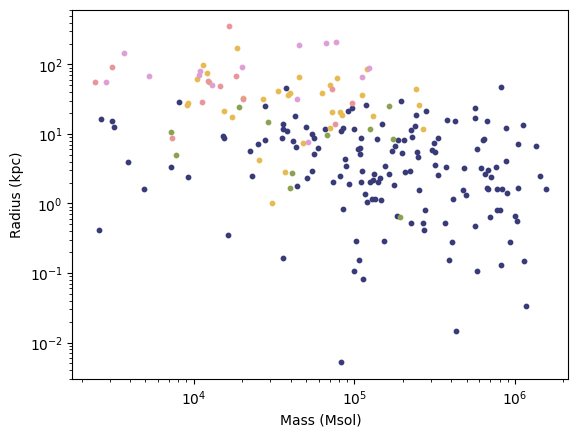

In [254]:
for grp in grp_unq:
    grp_mask = grp_lst == grp
    r_plot = np.array(r_lst)[grp_mask]
    mass_plot = np.array(mass_lst)[grp_mask]

    plt.scatter(mass_plot, r_plot, color=group_colors[grp], s=10)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Mass (Msol)")
plt.ylabel("Radius (kpc)")

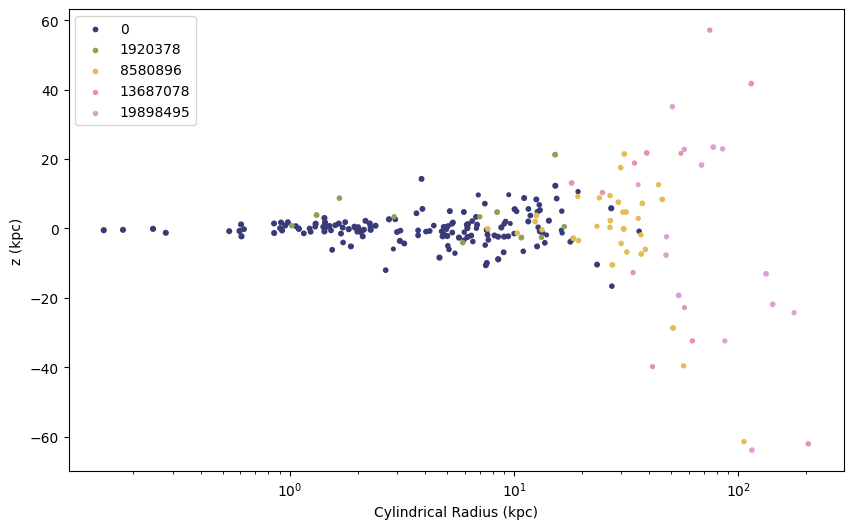

In [272]:
r_cyl_lst = proc_data["it000"]["snapshots"]["snap600"]["r_cyl"][()]
z_lst = proc_data["it000"]["snapshots"]["snap600"]["z"][()]

grp_lst = proc_data["it000"]["snapshots"]["snap600"]["group_id"][()]

log_mass_lst = proc_data["it000"]["snapshots"]["snap600"]["mass"][()]
# mass_lst = 10**log_mass_lst

plt.figure(figsize=(10, 6))
for grp in grp_unq:
    grp_mask = grp_lst == grp
    r_plot = np.array(r_cyl_lst)[grp_mask]
    z_plot = np.array(z_lst)[grp_mask]
    mass_plot = np.array(log_mass_lst)[grp_mask]

    plt.scatter(r_plot, z_plot, color=group_colors[grp], s=mass_plot * 2, label=grp)

plt.xscale("log")

plt.xlabel("Cylindrical Radius (kpc)")
plt.ylabel("z (kpc)")

plt.legend()